In [3]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame,date_range
from matplotlib import cm
import seaborn as sns
import scipy as sp
import math
import warnings
import glob,os
warnings.filterwarnings('ignore')

In [6]:
import glob
samplenameset = glob.glob('test_data/multi_Genome/Bactor/allfasta/ANI/chosen/*fasta')
samplenameset

['test_data/multi_Genome/Bactor/allfasta/ANI/chosen/am_BaFr_g0003_final.scaffolds.fasta',
 'test_data/multi_Genome/Bactor/allfasta/ANI/chosen/af_BaCa_g0001_final.scaffolds.fasta',
 'test_data/multi_Genome/Bactor/allfasta/ANI/chosen/am_BaFr_g0050.5e-04.SNP.fasta',
 'test_data/multi_Genome/Bactor/allfasta/ANI/chosen/bq_BaFr_g0001_final.scaffolds.fasta',
 'test_data/multi_Genome/Bactor/allfasta/ANI/chosen/av_BaFr_g0001_final.scaffolds.fasta',
 'test_data/multi_Genome/Bactor/allfasta/ANI/chosen/am_BaOv_g0001_final.scaffolds.fasta',
 'test_data/multi_Genome/Bactor/allfasta/ANI/chosen/am_BaFr_g0050.5e-02.SNP.fasta',
 'test_data/multi_Genome/Bactor/allfasta/ANI/chosen/am_BaFr_g0050.2e-02.SNP.fasta',
 'test_data/multi_Genome/Bactor/allfasta/ANI/chosen/am_BaFr_g0050.0.SNP.fasta',
 'test_data/multi_Genome/Bactor/allfasta/ANI/chosen/af_BaSt_g0001_final.scaffolds.fasta',
 'test_data/multi_Genome/Bactor/allfasta/ANI/chosen/cx_BaXy_g0001_final.scaffolds.fasta',
 'test_data/multi_Genome/Bactor/allfas

In [8]:
# load sams

import glob
import os
from Bio import SeqIO
from Bio.Seq import Seq
import argparse
import re
from multiprocessing import Process
from multiprocessing import Queue
from itertools import islice
from datetime import datetime
import psutil

pair_end_bonus = -100
samplenameset = glob.glob('test_data/multi_Genome/Bactor/allfasta/ANI/chosen/*fasta')
print(samplenameset)
toolset = {
    'mapper1':0,
    'bowtie':1,
    'bwa':2,
    'minimap':3,
    'strobealign':4,
    'last':5
}
penalty_set = ['bowtie','mapper','bwa','minimap']
max_penalty_set = {
    
    'mapper':0.1,
    'bowtie':0.6,
    'bwa':0.5,
    'minimap':0.6,
}

soft_clip_middle_penalty = 500
max_score = 1000
penalty_setscore = {
    'bowtie':[6,5,3,0,1],
    'minimap':[6,4,2,0,1],
    'bwa':[5,6,1,0,1],
    'mapper':[1,2,0.5,0,0.1]
}


def ref_read_chopbyCIGAR(readID, read,ref, CIGAR, CHRPOS,treat_soft_clip_as_N):
    # read,ref, CIGAR, CHRPOS,treat_soft_clip_as_N
    if CIGAR == '*':
        return max_score
    CIGARlenset = re.split('S|D|M|I|N|H|P|X|=', CIGAR)[:-1]
    i = 0
    kread = 0
    kref = 0
    readset = []
    refset = []
    penalty = 0
    #print('start',read,ref,CIGAR,CIGARlenset)
    CIGARlocus = 0
    for CIGARlen in CIGARlenset:
        i += len(CIGARlen)
        CIGARtype = CIGAR[i]
        #print('process CIGAR',CIGARtype,CIGARlen)
        i += 1
        if CIGARtype in (['M','X','=']):
            # matches
            readset += read[kread:(kread + int(CIGARlen))]
            refset += ref[kref:(kref + int(CIGARlen))]
            kread += int(CIGARlen)
            kref += int(CIGARlen)
            # print('M',penalty,kread,kref,''.join(readset),''.join(refset))
        elif CIGARtype == 'S' or CIGARtype == 'H':
            # clipping in read treat as ambiguous matches
            if treat_soft_clip_as_N:
                kread += int(CIGARlen)
                penalty += int(CIGARlen) * n_penalty
                # print('S', penalty,kread, kref)
            else:
                # insertion in read, no longer treated as ambiguous matches (because other tools do not)
                # what if the ref has all Ns at soft clipping regions?
                kread += int(CIGARlen)
                penalty += gapopen_penalty + int(CIGARlen) * gapextend_penalty + soft_clip_middle_penalty # + int(CIGARlen)*n_penalty
                if tool in ['minimap','bwa']:
                    read_with_softclips_in_middle_read.add(readID)
                # print('S->I', penalty, kread, kref)
        elif CIGARtype == 'I':
            # insertion in read, no longer treated as ambiguous matches (because other tools do not), because we can't verify that they match what was in the reference (because the reference had nothing there)
            kread += int(CIGARlen)
            penalty += gapopen_penalty + int(CIGARlen) * gapextend_penalty  # + int(CIGARlen)*n_penalty
            # print('I', penalty,kread, kref)
        elif CIGARtype == 'D':
            # insertion in ref
            kref += int(CIGARlen)
            penalty += gapopen_penalty + int(CIGARlen) * gapextend_penalty
            #print('D', penalty,kread, kref)
        elif CIGARtype == 'N':
            # skipped region from the reference
            kref += int(CIGARlen)
            penalty += int(CIGARlen)*n_penalty
            #print('N', penalty,kread, kref)
        elif CIGARtype == 'P':
            # hard clipping or padding
            pass
        CIGARlocus += 1
    return mismatch_check(readset,refset,penalty)

def load_ref(database):
    Ref = dict()
    for record in SeqIO.parse(database, 'fasta'):
        Ref.setdefault(str(record.id),str(record.seq))
    return Ref

def is_read_reverse_strand(flag):
    return bool(flag & 16)
def is_supplementary_alignment(flag):
    return bool(flag & 2048)

def mismatch_check(readset,refset,penalty):
    totallen = min(len(readset),len(refset))
    mismatch = 0
    nDNA = 0
    for i in range(0,totallen):
        if refset[i] == 'N' or readset[i]=='N':
            nDNA += 1
        elif readset[i] != refset[i]:
            mismatch += 1
    #print('total pennlty=',penalty+mismatch*mismatch_penalty + nDNA*n_penalty,'mismatch = ',mismatch,'nDNA=',nDNA)
    #print(penalty,mismatch,nDNA)
    final_penalty = (penalty + mismatch*mismatch_penalty + nDNA*n_penalty + (totallen-mismatch-nDNA)*match_penalty)
    #print('final penalty=',final_penalty,totallen,(totallen-mismatch-nDNA)*match_penalty)
    return final_penalty

def add_tag_tool(toolscore,toolCHRPOS,bestCHRPOS,bestscore):
    if bestscore == toolscore:
        return 'bestalignment'
    if max_score == toolscore:
        return 'alignmentmissed'
    toolCHR, toolPOS = toolCHRPOS.split('\t')
    try:
        bestCHR, bestPOS = bestCHRPOS.split('\t')
    except ValueError:
        print(toolscore,toolCHRPOS,bestCHRPOS,bestscore)
        return 'badalignment' # caused by S
    if toolCHR != bestCHR:
        return 'diffCHR'
    else:
        bestPOS = int(bestPOS)
        toolPOS = int(toolPOS)
        if bestPOS == toolPOS:
            return 'sameCHRsamePOS'
        elif toolPOS <= bestPOS + 100 and toolPOS >= bestPOS - 100:
            return 'sameCHRclosePOS'
        else:
            return 'sameCHRdiffPOS'

def add_tag(newscore,allCIGAR,allCHRPOS):
    tag2 = ''
    bestscore = min(newscore)
    besttool = newscore.index(bestscore)
    bestCIGAR = allCIGAR[besttool]
    bestCHRPOS = allCHRPOS[besttool]
    worstscore = max(newscore)
    worsttool = newscore.index(worstscore)
    worstCIGAR = allCIGAR[worsttool]
    if 'S' or 'H' in bestCIGAR:
        tag2 += 'RightSoft'
    if 'I' in bestCIGAR or 'D' in bestCIGAR:
        tag2 += 'RightIn'
    if 'S' or 'H' in worstCIGAR:
        tag2 += 'WrongSoft'
    if 'I' in worstCIGAR or 'D' in worstCIGAR:
        tag2 += 'WrongIn'
    if tag2 == '' and 'H' not in worstCIGAR and 'H' not in bestCIGAR and bestscore >= mismatch_penalty*5:
        tag2 += '>=5 SNPs'
    tagtool = []
    for i in range(0,len(newscore)):
        tagtool.append(add_tag_tool(newscore[i],allCHRPOS[i],bestCHRPOS,bestscore))
    return [tagtool,tag2,bestscore]

for samplename in samplenameset:
    samplename = os.path.basename(samplename).split('_final')[0].split('.fasta')[0]
    allref = glob.glob('test_data/multi_Genome/Bactor/allfasta/ANI/chosen/%s*fasta'%(samplename))[0]
    print(allref)
    Ref = load_ref(allref)
    for penaltyname in penalty_set:
            penaltylist = dict()
            read_with_softclips_in_middle_read = set()
            allread = dict()
            max_penalty = max_penalty_set[penaltyname]
            mismatch_penalty, gapopen_penalty, gapextend_penalty, match_penalty, n_penalty = penalty_setscore[penaltyname]
            print(penaltyname, mismatch_penalty, gapopen_penalty, gapextend_penalty, match_penalty, n_penalty,max_penalty)
            for tool in toolset:
                sam = 'SNP_model_penalty_pair/%s/am_BaFr_g0003_1.fastq_%s.%s.sam'%(penaltyname,samplename,tool)
                print(sam)
                position = toolset[tool]
                for lines in open(sam,'r'):
                    if not lines.startswith('@'):
                            lines_set = lines.split('\n')[0].split('\t')
                            CHR, POS = lines_set[2:4]
                            FLAG = int(lines_set[1])
                            read = lines_set[9].upper()
                            read_reverse = str(Seq(read).reverse_complement())
                            readname = lines_set[0]
                            allread.setdefault(readname,set())
                            complete_seq = True
                            if is_read_reverse_strand(FLAG):
                                readID = readname +'\t'+ read_reverse
                                if tool in ['bowtieN1','mapper','bwa','minimap','strobealign']:
                                    allread[readname].add(read_reverse)
                                elif tool == 'last':
                                    # last sometimes output incomplete query sequence
                                    for savedseq in allread[readname]:
                                        if len(read_reverse) < len(savedseq) and read_reverse in savedseq:
                                            readID = readname +'\t'+ savedseq
                                            complete_seq = False
                                            break
                            else:
                                readID = readname + '\t' + read
                                if tool in ['bowtieN1','mapper','bwa','minimap','strobealign']:
                                    allread[readname].add(read)
                                elif tool == 'last':
                                    # last sometimes output incomplete query sequence
                                    for savedseq in allread[readname]:
                                        if len(read) < len(savedseq) and read in savedseq:
                                            readID = readname +'\t'+ savedseq
                                            complete_seq = False
                                            break
                            CHR = CHR.split(' ')[0]
                            penaltylist.setdefault(readID,[
                                                   [max_score]*len(toolset),
                                ['']*len(toolset),['']*len(toolset),len(read)
                            ]
                                                  )
                            if CHR != '*' and not is_supplementary_alignment(FLAG):
                                CHRPOS = '%s\t%s'%(CHR,POS)
                                # read matches somewhere
                                CIGAR = lines_set[5]
                                reflen = len(Ref[CHR])
                                readlen = len(read)
                                POS = int(POS)
                                POSend = POS + readlen
                                treat_soft_clip_as_N = False
                                if POS <= 1 or POSend >= reflen:
                                    # possible soft clip when it's the end of the read
                                    treat_soft_clip_as_N = True
                                ref = Ref[CHR][(POS - 1):min(POSend, reflen)]
                                penalty = ref_read_chopbyCIGAR(readID,read,ref, CIGAR, CHRPOS,treat_soft_clip_as_N)
                                previous_penalty = penaltylist[readID][0][position]
                                if previous_penalty > penalty:
                                    penaltylist[readID][0][position] = penalty
                                    penaltylist[readID][1][position] = CIGAR
                                    penaltylist[readID][2][position] = CHRPOS
                                # if lines_set[0] == 'SL-NXA:H2H7HBGX3170812:H2H7HBGX3:3:11411:23494:4126':
                                #             print(treat_soft_clip_as_N,lines_set[0])
                                #             print(read)
                                #             print(ref,CHR,POS)
                                #             print(CIGAR)
                                #             print(FLAG, is_read_reverse_strand(FLAG))
                                #             print(penalty,previous_penalty)
                                #             break
            print('start process all final results')
            newresult = ['readID\tread\t%s\t%s\ttag2\tminpenalty\n'%('\t'.join(
            [x.replace('mapper1','mapper') for x in toolset]),'\t'.join(
            ['tag'+ x.replace('mapper1','mapper') for x in toolset])
            )]
            f1 = open('SNP_model_penalty_pair/%s/am_BaFr_g0003_1.fastq_%s.%s.samcompare.withtag.txt'%(penaltyname,samplename,penaltyname),'w')
            i = 0
            for readID in penaltylist:
                newscore,allCIGAR,allCHRPOS,readlen = penaltylist[readID]
                tagtool, tagtotal,bestscore = add_tag(newscore,allCIGAR,allCHRPOS)
                limitpenalty = readlen * max_penalty
                if min(newscore[0:4]) <= limitpenalty:
                    newresult.append('%s\t%s\t%s\t%s\t%s\n'%(
                    readID,'\t'.join([str(x) for x in newscore]),'\t'.join(tagtool),tagtotal,bestscore
                    ))
                    i += 1
                    if i%10000 == 0:
                        f1.write(''.join(newresult))
                        #print('output %s lines'%(i))
                        newresult = []
            f1.write(''.join(newresult))
            f1.close()
            print('start process clean final results')
            newresult = ['readID\tread\t%s\t%s\ttag2\tminpenalty\n'%('\t'.join(
                [x.replace('mapper1','mapper') for x in toolset]),'\t'.join(
                ['tag'+ x.replace('mapper1','mapper') for x in toolset])
                )]
            f1 = open('SNP_model_penalty_pair/%s/am_BaFr_g0003_1.fastq_%s.%s.samcompare.withtagclean.txt'%(penaltyname,samplename,penaltyname),'w')
            i = 0
            for readID in penaltylist:
                newscore,allCIGAR,allCHRPOS,readlen = penaltylist[readID]
                tagtool, tagtotal,bestscore = add_tag(newscore,allCIGAR,allCHRPOS)
                limitpenalty = readlen * max_penalty
                if min(newscore[0:4]) <= limitpenalty:
                    if readID not in read_with_softclips_in_middle_read:
                        newresult.append('%s\t%s\t%s\t%s\t%s\n'%(
                    readID,'\t'.join([str(x) for x in newscore]),'\t'.join(tagtool),tagtotal,bestscore
                    ))
                        i += 1
                        if i%10000 == 0:
                            f1.write(''.join(newresult))
                            #print('output %s lines'%(i))
                            newresult = []      
            f1.write(''.join(newresult))
            f1.close()


['test_data/multi_Genome/Bactor/allfasta/ANI/chosen/am_BaFr_g0003_final.scaffolds.fasta', 'test_data/multi_Genome/Bactor/allfasta/ANI/chosen/af_BaCa_g0001_final.scaffolds.fasta', 'test_data/multi_Genome/Bactor/allfasta/ANI/chosen/am_BaFr_g0050.5e-04.SNP.fasta', 'test_data/multi_Genome/Bactor/allfasta/ANI/chosen/bq_BaFr_g0001_final.scaffolds.fasta', 'test_data/multi_Genome/Bactor/allfasta/ANI/chosen/av_BaFr_g0001_final.scaffolds.fasta', 'test_data/multi_Genome/Bactor/allfasta/ANI/chosen/am_BaOv_g0001_final.scaffolds.fasta', 'test_data/multi_Genome/Bactor/allfasta/ANI/chosen/am_BaFr_g0050.5e-02.SNP.fasta', 'test_data/multi_Genome/Bactor/allfasta/ANI/chosen/am_BaFr_g0050.2e-02.SNP.fasta', 'test_data/multi_Genome/Bactor/allfasta/ANI/chosen/am_BaFr_g0050.0.SNP.fasta', 'test_data/multi_Genome/Bactor/allfasta/ANI/chosen/af_BaSt_g0001_final.scaffolds.fasta', 'test_data/multi_Genome/Bactor/allfasta/ANI/chosen/cx_BaXy_g0001_final.scaffolds.fasta', 'test_data/multi_Genome/Bactor/allfasta/ANI/chos

In [12]:
%reset -f

In [15]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame,date_range
from matplotlib import cm
import seaborn as sns
import scipy as sp
import math
import warnings
import glob,os
warnings.filterwarnings('ignore')
score = pd.read_csv('SNP_model_penalty_pair//bowtie/am_BaFr_g0003_1.fastq_am_BaFr_g0003.bowtie.samcompare.withtag.txt',
                    sep='\t')
score.head()

,readID,read,mapper,bowtie,bwa,minimap,strobealign,last,tagmapper,tagbowtie,tagbwa,tagminimap,tagstrobealign,taglast,tag2,minpenalty
0,SL-NXA:HYWK2BGXY161224:HYWK2BGXY:1:11101:10730...,ATTTATTGCACTCCTCTTATTTCTCTCTCTTCCTTATTGTTGCGTT...,0,0,0,0,0,0,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,RightSoftWrongSoft,0
1,SL-NXA:HYWK2BGXY161224:HYWK2BGXY:1:11101:10276...,CTTTTGGTGTGGGATATTTCACGATTAACGCGTTTATGAATGATGG...,0,0,0,0,0,0,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,RightSoftWrongSoft,0
2,SL-NXA:HYWK2BGXY161224:HYWK2BGXY:1:11101:11341...,ATGATACACTGATATATGGAAGAACGTTATTATCAACAGAAATATG...,0,0,0,0,0,0,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,RightSoftWrongSoft,0
3,SL-NXA:HYWK2BGXY161224:HYWK2BGXY:1:11101:11429...,CCTTGGCACCCACTTCATCAACATTTATCTCTCTGCCCTGATAAAT...,6,6,6,6,6,6,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,RightSoftWrongSoft,6
4,SL-NXA:HYWK2BGXY161224:HYWK2BGXY:1:11101:10543...,GTCAAATACCATCCAATTGTCAGAGCCTATAATCAACTGGAATTCT...,0,0,0,0,0,0,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,bestalignment,RightSoftWrongSoft,0


In [16]:
print(score.shape,
    score[score['mapper']>score['minpenalty']].shape,
     score[score['bowtie']>score['minpenalty']].shape,
      score[score['bwa']>score['minpenalty']].shape,
     score[score['minimap']>score['minpenalty']].shape,
    score[score['strobealign']>score['minpenalty']].shape,
      score[score['last']>score['minpenalty']].shape,
     )
# #(56, 18) (60930, 18) (8056, 18) (47582, 18)
# #(34, 18) (101, 18) (1238, 18) (9386, 18)
#(24585, 26) (31896, 26) (86454, 26) (33253, 26) (68070, 26)
# (1699, 26) (23947, 26) (17661, 26) (31960, 26) (60105, 26) (8765, 26) (41325, 26) # clean
# (3510, 26) (38280, 26) (20148, 26) (34579, 26) (63627, 26) (10781, 26) (43770, 26) # not clean
#(1671, 26) (23674, 26) (17361, 26) (31644, 26) (59839, 26) (8716, 26) (41190, 26)# clean
# (2593106, 28) (3369, 28) (34167, 28) (14506, 28) (29198, 28) (62871, 28) (10574, 28) (43399, 28) (118345, 28) strobealign with penalty
# (2579147, 28) (3762, 28) (30084, 28) (11621, 28) (27168, 28) (62013, 28) (10863, 28) (43215, 28) (72918, 28) strobealign without changing penalty


(1606286, 16) (292, 16) (17741, 16) (22955, 16) (16516, 16) (60733, 16) (21818, 16)


In [17]:
### penalty
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame,date_range
from matplotlib import cm
import seaborn as sns
import scipy as sp
import math
import warnings
import glob,os
warnings.filterwarnings('ignore')
max_penalty = {'bowtie':0.6,
              'bwa':0.5,
              'minimap':0.6,
              'mapper':1.0}
palette_set = {
    'bowtie2':'#878787','bowtie2 with seed mismatches':'#525252','minimap2':'#bababa','bwa':'#e0e0e0','mapper':'#ca0020',
    'strobealign':'#000000',
    'last':'#252525',
    'mapper 12mer':'#c6dbef',
    'mapper 14mer':'#9ecae1',
    'mapper 16mer':'#6baed6',
     'mapper 18mer':'#4292c6',
    'mapper 20mer':'#2171b5',
    'mapper 22mer':'#08519c',
    'mapper 24mer':'#08306b',
        'bowtie2 all':'#2166ac','minimap2 all':'#67a9cf','bwa all':'#d1e5f0'
    }
def compute_accuracy(samfile,tool,total_reads):
    score=pd.read_csv(samfile, sep='\t')
    score = score.drop_duplicates('readID') # remove short reads of the same ID, partial alignment by minimap and bwa
    num_reads_no_diff = total_reads - score.shape[0]
    score_sum = {'tool':['bowtie2 with seed mismatches','bwa','minimap2','mapper','strobealign','last'],
                 'value':[0,0,0,0,0,0]}
    #score['minpenaltyall']=score.iloc[:,3:].min(axis=1)
    score_sum['value'][0]=score[score['bowtie']<=score['minpenalty']].shape[0]
    score_sum['value'][1]=score[score['bwa']<=score['minpenalty']].shape[0]
    score_sum['value'][2]=score[score['minimap']<=score['minpenalty']].shape[0]
    score_sum['value'][3]=score[score['mapper']<=score['minpenalty']].shape[0]
    score_sum['value'][4]=score[score['strobealign']<=score['minpenalty']].shape[0]
    score_sum['value'][5]=score[score['last']<=score['minpenalty']].shape[0]
    score_sum=pd.DataFrame(score_sum)
    score_sum['value']=score_sum['value']
    score_sum['accuracy']=(score_sum['value'] + num_reads_no_diff)/total_reads*100
    print(tool,'reads no diff =',num_reads_no_diff/total_reads,num_reads_no_diff,'reads with diff=',score.shape[0]/total_reads,score.shape[0])
    return [score_sum,num_reads_no_diff/total_reads*100]
folder = 'SNP_model_penalty_pair/'


am_BaFr_g0003
['SNP_model_penalty_pair/bowtie/am_BaFr_g0003_1.fastq_am_BaFr_g0003.bowtie.samcompare.withtagclean.txt', 'SNP_model_penalty_pair/bwa/am_BaFr_g0003_1.fastq_am_BaFr_g0003.bwa.samcompare.withtagclean.txt', 'SNP_model_penalty_pair/mapper/am_BaFr_g0003_1.fastq_am_BaFr_g0003.mapper.samcompare.withtagclean.txt', 'SNP_model_penalty_pair/minimap/am_BaFr_g0003_1.fastq_am_BaFr_g0003.minimap.samcompare.withtagclean.txt']
bowtie reads no diff = 0.030030062878634575 49416.0 reads with diff= 0.9699699371213655 1596135
bwa reads no diff = 0.028801902827685074 47395.0 reads with diff= 0.971198097172315 1598156
mapper reads no diff = 0.039038595582877714 64240.0 reads with diff= 0.9609614044171223 1581311
minimap reads no diff = 0.036373226961668156 59854.0 reads with diff= 0.9636267730383319 1585697
af_BaCa_g0001
['SNP_model_penalty_pair/bowtie/am_BaFr_g0003_1.fastq_af_BaCa_g0001.bowtie.samcompare.withtagclean.txt', 'SNP_model_penalty_pair/bwa/am_BaFr_g0003_1.fastq_af_BaCa_g0001.bwa.samco

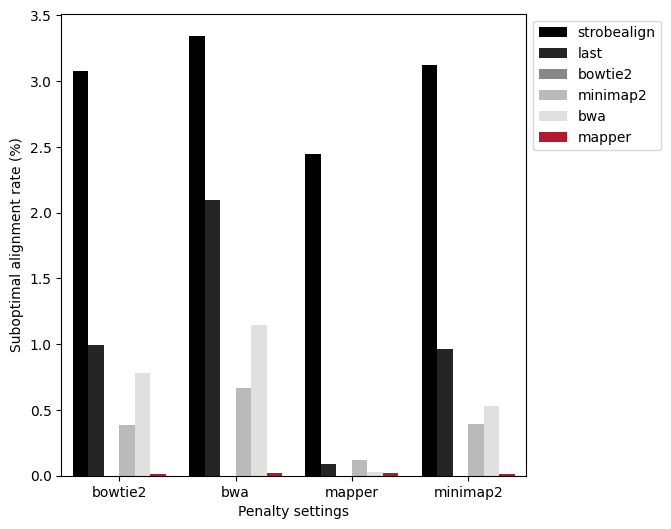

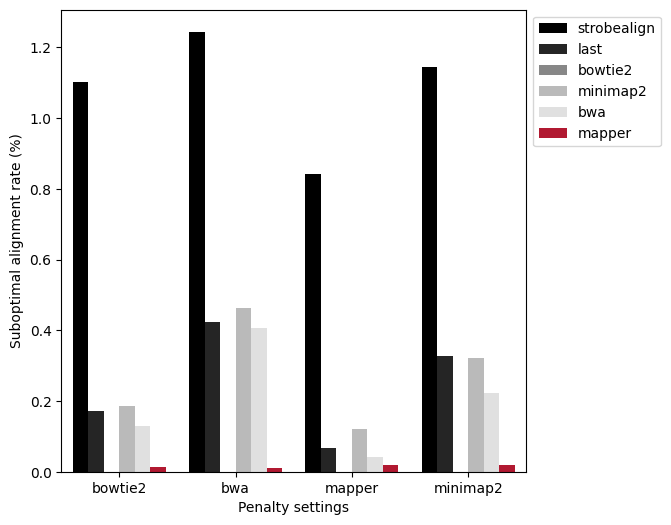

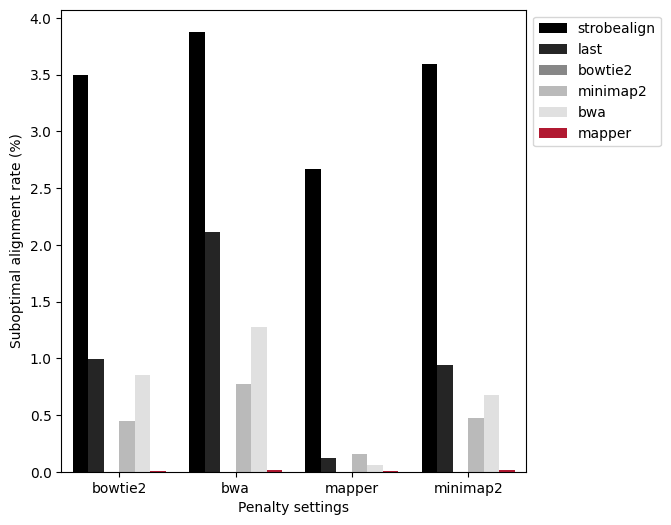

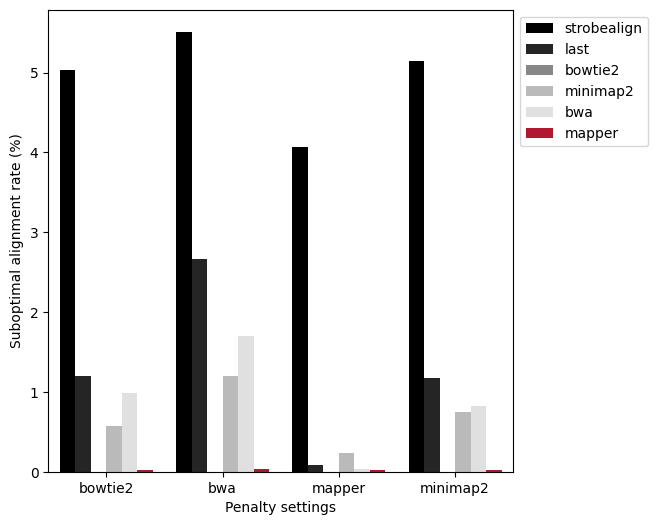

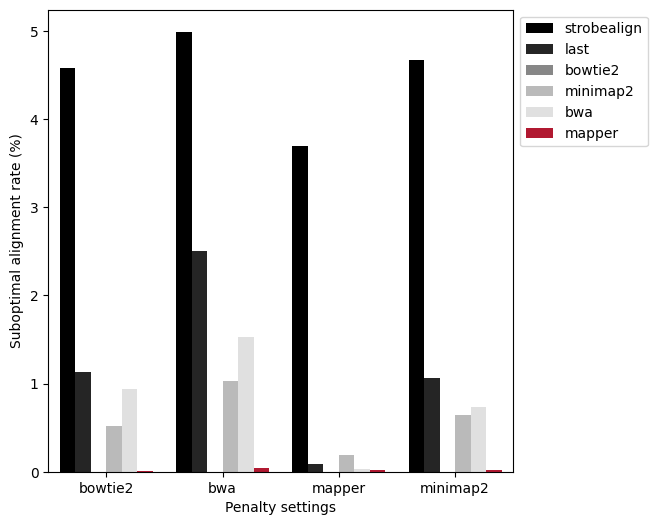

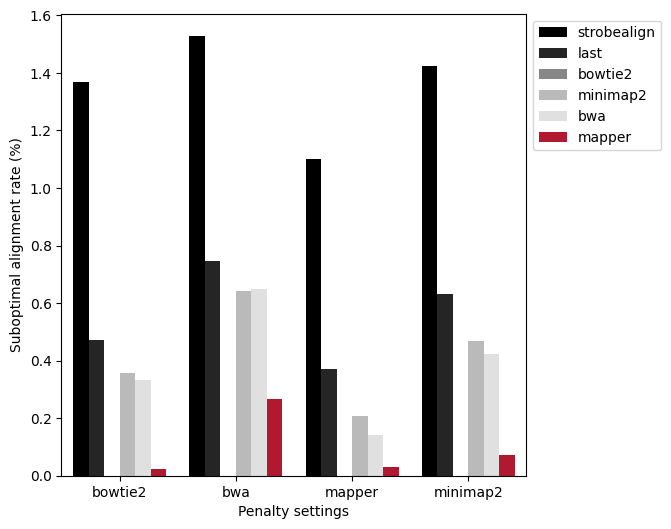

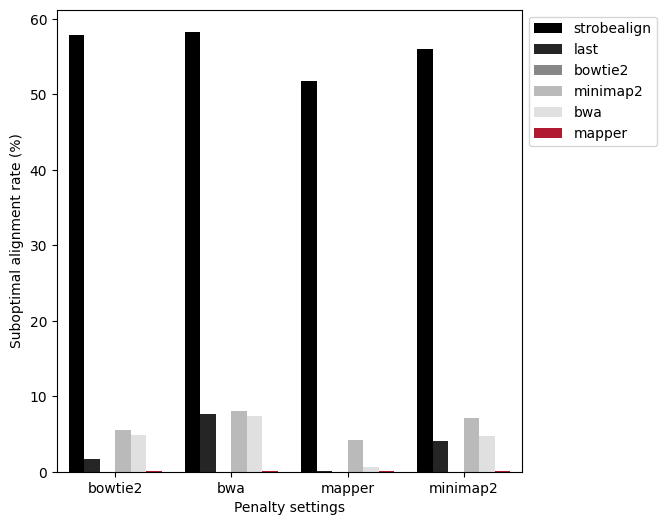

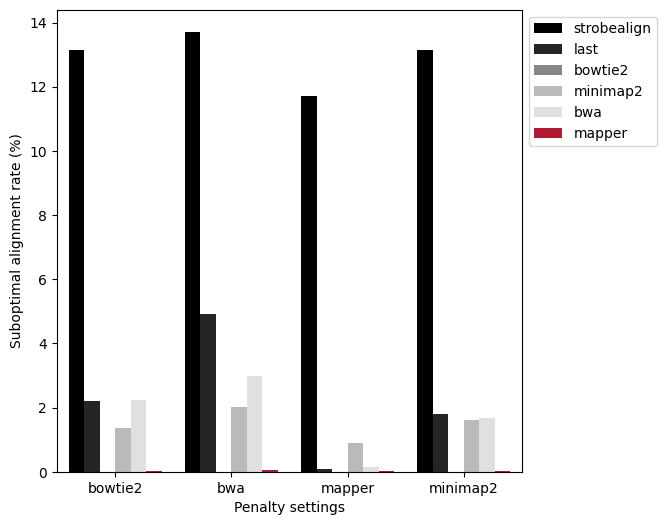

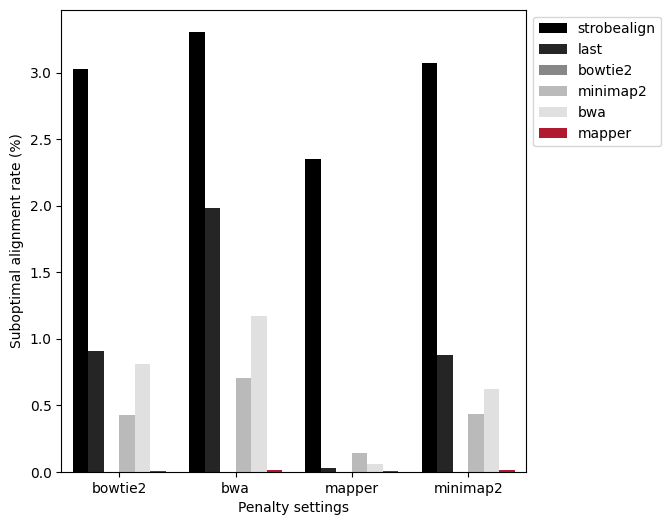

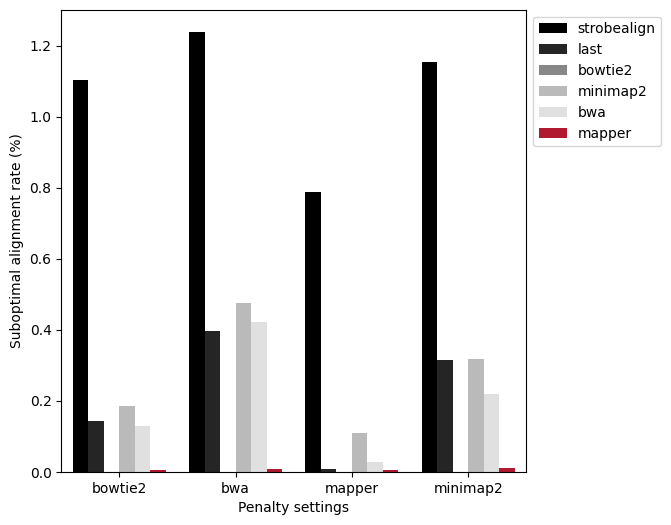

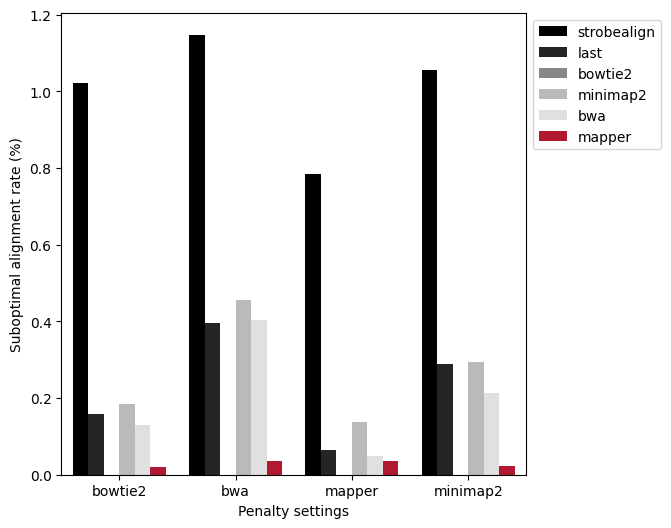

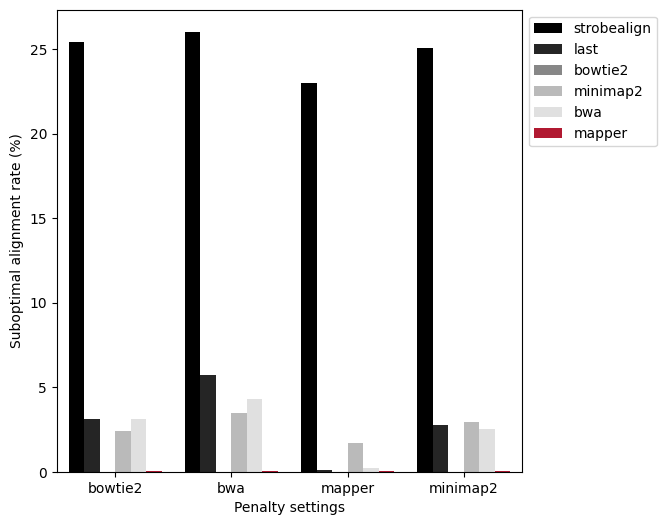

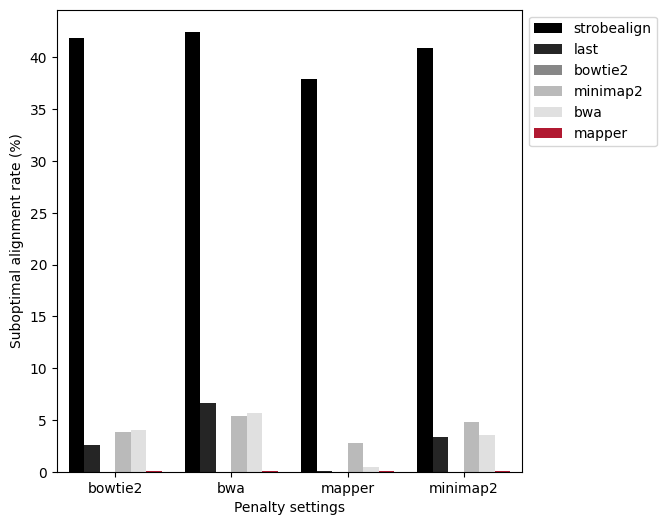

In [18]:
### penalty MG
# accuracy = (total_reads-reads_with_diff + reads_lowest_penalty_tool)/total_reads, max(accuracy = 100%)
total_reads = 6582204/4
allfasta = glob.glob('test_data/multi_Genome/Bactor/allfasta/ANI/chosen/*fasta')
allscoreall = pd.DataFrame()
for fasta in allfasta:
    fasta = os.path.basename(fasta).split('_final')[0].split('.fasta')[0]
    print(fasta)
    allsam = glob.glob('%s/*/am_BaFr_g0003_1.fastq_%s.*.samcompare.withtagclean.txt'%(folder,fasta))
    allsam.sort()
    print(allsam)
    allscore = pd.DataFrame()
    for samfile in allsam:
        tool = os.path.split(samfile)[-1].split('.samcompare.withtag')[0].split('.')[-1]
        score_sum,ymin = compute_accuracy(samfile,tool,total_reads)
        score_sum['penalty'] = tool.replace('bowtie','bowtie2').replace('minimap','minimap2')
        allscore = allscore.append(score_sum)
    toolset1 = ['strobealign','last','bowtie2','bwa','minimap2','mapper'
                             ]
    
    legend_order = ['strobealign','last','bowtie2','minimap2','bwa','mapper']
    allscore['inaccuracy'] = 100 - allscore['accuracy']
    allscore['fasta'] = fasta
    fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(6, 6))
    allscoresub = allscore[allscore['tool'].isin(toolset1)]
    allscoresub['tool'] = [x.replace('mapper (noancestor)','mapper') for x in allscoresub['tool']]
    sns.barplot(x='penalty', y='inaccuracy', data=allscoresub,ax=axs,hue = 'tool',palette=palette_set,
                hue_order = legend_order,
                     dodge=True)
    axs.set_ylabel('Suboptimal alignment rate (%)') 
    axs.set_xlabel('Penalty settings') 
    plt.legend(bbox_to_anchor=(1.0, 1.0)) 
    plt.savefig('%s/%s_allclean.pdf'%(folder,fasta),bbox_inches='tight')
    allscoreall = allscoreall.append(allscore)
allscoreall.to_csv('%s/ANI_accuracy_clean.txt'%(folder),sep='\t',index = False)


In [19]:
# add ANI value
ANI = pd.read_csv("test_data/multi_Genome/Bactor/allfasta/ANI/chosen/fastANI.txt",sep='\t',header=None)
allscoreall = pd.read_csv("SNP_model_penalty_pair/ANI_accuracy_clean.txt",sep='\t')
ANI['fasta'] = [x.replace('.fasta.corrected','').split('_final')[0].split('.fasta')[0] for x in ANI[1]]
ANI['ANI'] = ['%.2f'%x for x in ANI[2]]
ANI.head()


,0,1,2,3,4,fasta,ANI
0,am_BaFr_g0003_final.scaffolds.fasta,am_BaFr_g0003_final.scaffolds.fasta,100.0000,1713,1713,am_BaFr_g0003,100.00
1,am_BaFr_g0003_final.scaffolds.fasta,am_BaFr_g0050.fasta.corrected.0.SNP.fasta,99.9932,1707,1713,am_BaFr_g0050.0.SNP,99.99
2,am_BaFr_g0003_final.scaffolds.fasta,am_BaFr_g0050.fasta.corrected.5e-04.SNP.fasta,99.9228,1707,1713,am_BaFr_g0050.5e-04.SNP,99.92
3,am_BaFr_g0003_final.scaffolds.fasta,av_BaFr_g0001_final.scaffolds.fasta,99.1136,1435,1713,av_BaFr_g0001,99.11
4,am_BaFr_g0003_final.scaffolds.fasta,bq_BaFr_g0001_final.scaffolds.fasta,98.5547,1407,1713,bq_BaFr_g0001,98.55


In [20]:
print(allscoreall['fasta'].unique(),ANI['fasta'].unique())

['am_BaFr_g0003' 'af_BaCa_g0001' 'am_BaFr_g0050.5e-04.SNP' 'bq_BaFr_g0001'
 'av_BaFr_g0001' 'am_BaOv_g0001' 'am_BaFr_g0050.5e-02.SNP'
 'am_BaFr_g0050.2e-02.SNP' 'am_BaFr_g0050.0.SNP' 'af_BaSt_g0001'
 'cx_BaXy_g0001' 'am_BaFr_g0050.3e-02.SNP' 'am_BaFr_g0050.4e-02.SNP'] ['am_BaFr_g0003' 'am_BaFr_g0050.0.SNP' 'am_BaFr_g0050.5e-04.SNP'
 'av_BaFr_g0001' 'bq_BaFr_g0001' 'am_BaFr_g0050.2e-02.SNP'
 'am_BaFr_g0050.3e-02.SNP' 'am_BaFr_g0050.4e-02.SNP'
 'am_BaFr_g0050.5e-02.SNP' 'am_BaOv_g0001' 'af_BaSt_g0001' 'af_BaCa_g0001'
 'cx_BaXy_g0001']


In [21]:
allscoreall = allscoreall.merge(ANI,left_on = 'fasta',right_on = 'fasta',how = 'outer')
allscoreall.tail()

,tool,value,accuracy,penalty,inaccuracy,fasta,0,1,2,3,4,ANI
307,bwa,1437456,96.458329,minimap2,3.541671,am_BaFr_g0050.4e-02.SNP,am_BaFr_g0003_final.scaffolds.fasta,am_BaFr_g0050.fasta.corrected.4e-02.SNP.fasta,95.4735,1700,1713,95.47
308,minimap2,1416760,95.200635,minimap2,4.799365,am_BaFr_g0050.4e-02.SNP,am_BaFr_g0003_final.scaffolds.fasta,am_BaFr_g0050.fasta.corrected.4e-02.SNP.fasta,95.4735,1700,1713,95.47
309,mapper,1494306,99.913099,minimap2,0.086901,am_BaFr_g0050.4e-02.SNP,am_BaFr_g0003_final.scaffolds.fasta,am_BaFr_g0050.fasta.corrected.4e-02.SNP.fasta,95.4735,1700,1713,95.47
310,strobealign,822953,59.115032,minimap2,40.884968,am_BaFr_g0050.4e-02.SNP,am_BaFr_g0003_final.scaffolds.fasta,am_BaFr_g0050.fasta.corrected.4e-02.SNP.fasta,95.4735,1700,1713,95.47
311,last,1439864,96.604663,minimap2,3.395337,am_BaFr_g0050.4e-02.SNP,am_BaFr_g0003_final.scaffolds.fasta,am_BaFr_g0050.fasta.corrected.4e-02.SNP.fasta,95.4735,1700,1713,95.47


In [22]:
allscoreall[allscoreall['tool']=='mapper'].sort_values("inaccuracy").tail()

,tool,value,accuracy,penalty,inaccuracy,fasta,0,1,2,3,4,ANI
147,mapper,1517849,99.910790,bowtie2,0.089210,am_BaFr_g0050.5e-02.SNP,am_BaFr_g0003_final.scaffolds.fasta,am_BaFr_g0050.fasta.corrected.5e-02.SNP.fasta,94.3944,1697,1713,94.39
297,mapper,1542508,99.900033,bwa,0.099967,am_BaFr_g0050.4e-02.SNP,am_BaFr_g0003_final.scaffolds.fasta,am_BaFr_g0050.fasta.corrected.4e-02.SNP.fasta,95.4735,1700,1713,95.47
165,mapper,1465066,99.861566,minimap2,0.138434,am_BaFr_g0050.5e-02.SNP,am_BaFr_g0003_final.scaffolds.fasta,am_BaFr_g0050.fasta.corrected.5e-02.SNP.fasta,94.3944,1697,1713,94.39
153,mapper,1517285,99.859014,bwa,0.140986,am_BaFr_g0050.5e-02.SNP,am_BaFr_g0003_final.scaffolds.fasta,am_BaFr_g0050.fasta.corrected.5e-02.SNP.fasta,94.3944,1697,1713,94.39
129,mapper,89069,99.734132,bwa,0.265868,am_BaOv_g0001,am_BaFr_g0003_final.scaffolds.fasta,am_BaOv_g0001_final.scaffolds.fasta,81.2902,404,1713,81.29


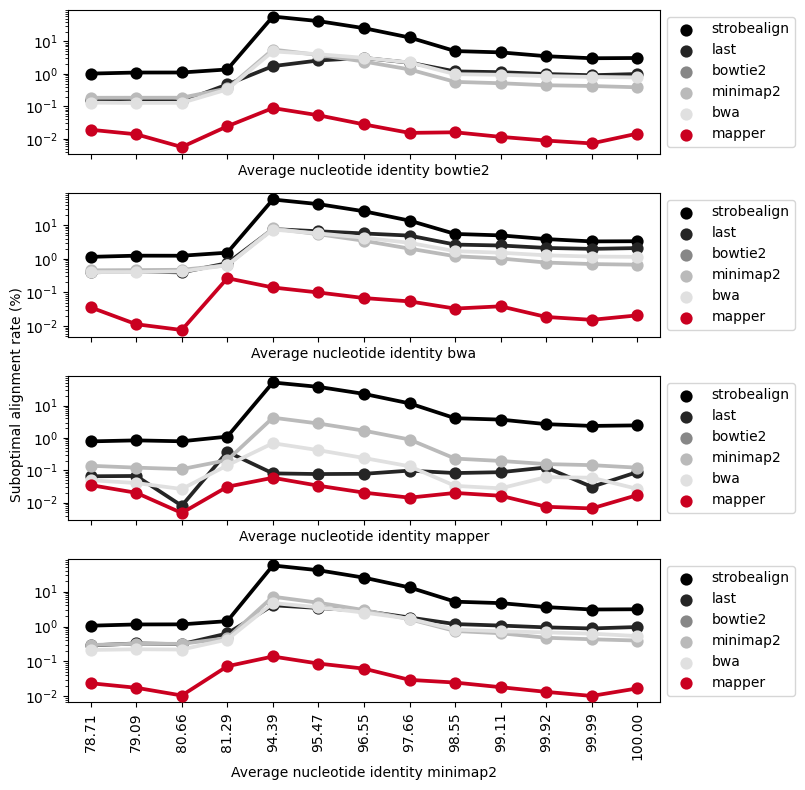

In [23]:
import matplotlib.ticker as mticker

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(8, 8),sharex = 1)
allpenalty = allscoreall['penalty'].unique()
allscoreall = allscoreall.sort_values(2)
for i in range(4):
    penalty = allpenalty[i]
    sns.pointplot(x='ANI', y='inaccuracy', data=allscoreall[allscoreall['penalty'] == penalty],
                  ax=axs[i], hue='tool', palette=palette_set, hue_order=legend_order)
    axs[i].set_xlabel('Average nucleotide identity %s'%(penalty))
    axs[i].set_ylabel('')
    axs[i].set_yscale('log')  # Apply log10 scale to y-axis
    axs[i].legend(bbox_to_anchor=(1.0, 1.0))  # Set legend position
    axs[i].tick_params(axis='x', rotation=90)  # Rotate x-axis ticks by 90 degrees
    
# Add one common y-axis label
fig.text(0, 0.5, 'Suboptimal alignment rate (%)', va='center', rotation='vertical')

plt.tight_layout()
plt.savefig('%s/allclean.pdf' % folder, bbox_inches='tight')


In [25]:
%reset -f

In [ ]:
### end